## Full Integer Quantization

### Inspecting Dataset

In [35]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf

AttributeError: module 'numpy' has no attribute 'vectorize'

In [2]:
def parse_function(image_size, raw_image_key_name):
  """Generate parse function for parsing the TFRecord training dataset.
  Read the image example and resize it to desired size.
  Args:
    image_size: int, target size to resize the image to
    raw_image_key_name: str, name of the JPEG image in each TFRecord entry
  Returns:
    A map function to use with tf.data.Dataset.map() .
  """

  def func(example_proto):
    """A generator to be used as representative_dataset for TFLiteConverter."""
    image_raw = tf.io.parse_single_example(
        example_proto,
        features={raw_image_key_name: tf.io.FixedLenFeature([], tf.string)},
    )
    image = tf.image.decode_jpeg(image_raw[raw_image_key_name])
    image = tf.expand_dims(image, axis=0)
    image = tf.image.resize(image, (image_size, image_size)) # bilinear is default
    image = tf.squeeze(image, axis=0)
    image = image / 255.0
    return image

  return func

In [3]:
def rgb_filter_function(image):
  """Filter function that only lets RGB images go through.
  Args:
    image: Tensor, the image tensor to be checked.
  Returns: bool, whether to keep the image or not.
  """
  shape = tf.shape(image)[2]
  return tf.math.equal(shape, 3)

In [4]:
def get_calibration_dataset(content_image_size, imagenet_data_dir):
  """Generate calibration dataset from the training dataset.
  Args:
    content_image_size: int, image size to resize the training images to.
    imagenet_data_dir: str, path to the ImageNet data.
  Returns:
    content_dataset: str, Path to the style dataset and content dataset for calibration.
  """

  # Load content dataset
  tf_record_pattern = os.path.join(imagenet_data_dir, 'coco_train.record-*****-of-00020')
  data_files = tf.io.gfile.glob(tf_record_pattern)
  content_dataset = tf.data.TFRecordDataset(data_files)
  content_dataset = content_dataset.map(
      parse_function(content_image_size, 'image/encoded'))
  content_dataset = content_dataset.filter(rgb_filter_function)

  return content_dataset

In [5]:
# Create the datasets
content_dataset = get_calibration_dataset(640, '/home/sommarjobbare/tf2_models/models/tfrecords')

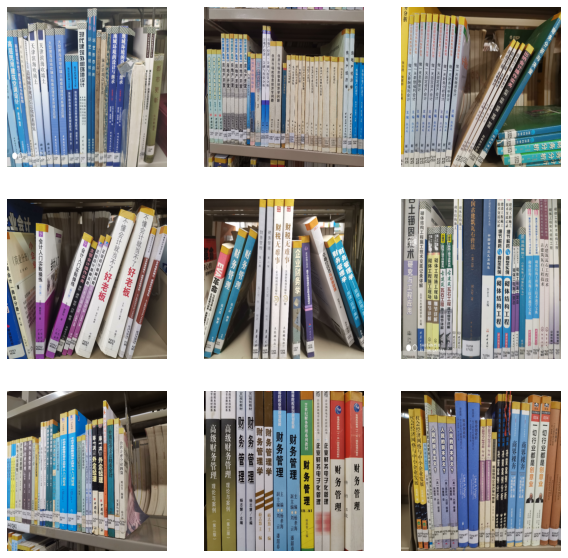

In [6]:
# Visualize the images
plt.figure(figsize=(10, 10))
for i, image in enumerate(content_dataset.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image)
  plt.axis('off')

### Inspecting Saved Model

In [7]:
saved_model_path = '/home/sommarjobbare/tf2_models/models/checkpoint_mn/export_dir/saved_model'
predict_graph = tf.saved_model.load(saved_model_path)
concrete_func = predict_graph.signatures['serving_default']
print(concrete_func.inputs)
print(concrete_func.structured_outputs)

[<tf.Tensor 'input:0' shape=(1, 640, 640, 3) dtype=float32>, <tf.Tensor 'unknown:0' shape=() dtype=resource>, <tf.Tensor 'unknown_0:0' shape=() dtype=resource>, <tf.Tensor 'unknown_1:0' shape=() dtype=resource>, <tf.Tensor 'unknown_2:0' shape=() dtype=resource>, <tf.Tensor 'unknown_3:0' shape=() dtype=resource>, <tf.Tensor 'unknown_4:0' shape=() dtype=resource>, <tf.Tensor 'unknown_5:0' shape=() dtype=resource>, <tf.Tensor 'unknown_6:0' shape=() dtype=resource>, <tf.Tensor 'unknown_7:0' shape=() dtype=resource>, <tf.Tensor 'unknown_8:0' shape=() dtype=resource>, <tf.Tensor 'unknown_9:0' shape=() dtype=resource>, <tf.Tensor 'unknown_10:0' shape=() dtype=resource>, <tf.Tensor 'unknown_11:0' shape=() dtype=resource>, <tf.Tensor 'unknown_12:0' shape=() dtype=resource>, <tf.Tensor 'unknown_13:0' shape=() dtype=resource>, <tf.Tensor 'unknown_14:0' shape=() dtype=resource>, <tf.Tensor 'unknown_15:0' shape=() dtype=resource>, <tf.Tensor 'unknown_16:0' shape=() dtype=resource>, <tf.Tensor 'unkn

### Creating Representative Dataset Generator

In [8]:
def dataset_rep():
    for image in content_dataset.take(100):
        yield [tf.expand_dims(image, 0)]

In [9]:
# Int8 quantization
def convert_tflite_model_dynamic(saved_model_path, tflite_path, type='style_predict'):
#     model = tf.saved_model.load(saved_model_path)
#     concrete_func = model.signatures[
#         tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
#     concrete_func.inputs[0].set_shape([1, 640, 640, 3])    
#     converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
    
    converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = dataset_rep
    
    tflite_model = converter.convert()

    with tf.io.gfile.GFile(tflite_path, 'wb') as f:
        f.write(tflite_model)

    print('Quantized model:', tflite_path, 
        'Size:', len(tflite_model) / 1024, "kb")

In [10]:
convert_tflite_model_dynamic(saved_model_path, 'detect_mn.tflite')

Quantized model: detect_mn.tflite Size: 0.421875 kb


In [11]:
# saved_model = tf.saved_model.load(saved_model_path)
# concrete_func = saved_model.signatures["serving_default"]
# concrete_func.inputs[0].set_shape([1, 640, 640, 3])
# converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])

# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.representative_dataset = dataset_rep
# converter.experimental_new_converter=True
# converter.target_spec.supported_ops=[tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# converter.inference_input_type = tf.uint8 # or tf.uint8
# converter.inference_output_type = tf.uint8 # or tf.uint8

# tflite_model = converter.convert()
# open("detect_mn.tflite", "wb").write(tflite_model)


# import glob
# from random import shuffle, seed
# from PIL import Image
# import numpy as np

# converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)

# converter.target_spec.supported_ops = [
#   tf.lite.OpsSet.TFLITE_BUILTINS_INT8,
#   tf.lite.OpsSet.SELECT_TF_OPS,
#   ]

# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.representative_dataset = dataset_rep

# tflite_model = converter.convert()
# open("detect_mn_int8.tflite", "wb").write(tflite_model)

# saved_model = tf.saved_model.load("/home/sommarjobbare/tf2_models/models/checkpoint_cn/export_dir/saved_model")
# concrete_func = saved_model.signatures["serving_default"]
# concrete_func.inputs[0].set_shape([1, 512, 512, 3])
# converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
# tflite_model = converter.convert()
# open("model.tflite", "wb").write(tflite_model)